## 0. Imports

In [116]:
import requests
import json
from tqdm import tqdm
import matplotlib.pyplot as plt

## 1. Get Access Token
Use the spotify developer credentials in the `credentials.json` file to generate an access token (valid for 1 hour).

In [162]:
def get_spotify_access_token():
    # Read the credentials from the JSON file
    with open("credentials.json", 'r') as file:
        credentials = json.load(file)
        client_id = credentials["client_id"]
        client_secret = credentials["client_secret"]
        
    # Get access token from spotify
    url = "https://accounts.spotify.com/api/token"
    headers = {"Content-Type": "application/x-www-form-urlencoded"}
    data = {"grant_type": "client_credentials", "client_id": client_id, "client_secret": client_secret}

    response = requests.post(url, headers=headers, data=data)
    
    if response.status_code == 200:
        return response.json()["access_token"]
    else:
        print(f"Access token request failed, Status Code: {response.status_code}")
        return None

In [13]:
access_token = get_spotify_access_token()

## 2. Get Playlist Content
Fetch complete playlist data from a playlist id

In [55]:
def get_playlist_content(playlist_id):
    url = "https://api.spotify.com/v1/playlists/" + playlist_id
    headers = {"Authorization": "Bearer " + access_token}
    
    base_response = requests.get(url, headers=headers)
    print(f"Requested: {url}, Status Code: {base_response.status_code}")
    base_response_json = base_response.json()
    next_url = base_response_json["tracks"]["next"]
    
    while next_url is not None:
        response = requests.get(next_url, headers=headers)
        print(f"Requested: {next_url}, Status Code: {response.status_code}")
        additional_tracks = response.json()
        base_response_json["tracks"]["items"].extend(additional_tracks["items"])
        next_url = additional_tracks["next"]
    
    return base_response_json

In [56]:
playlist_json = get_playlist_content(playlist_id="4hnDUcviGrwCf46xa7vzfR")

Requested: https://api.spotify.com/v1/playlists/4hnDUcviGrwCf46xa7vzfR, Status Code: 200
Requested: https://api.spotify.com/v1/playlists/4hnDUcviGrwCf46xa7vzfR/tracks?offset=100&limit=100, Status Code: 200
Requested: https://api.spotify.com/v1/playlists/4hnDUcviGrwCf46xa7vzfR/tracks?offset=200&limit=100, Status Code: 200
Requested: https://api.spotify.com/v1/playlists/4hnDUcviGrwCf46xa7vzfR/tracks?offset=300&limit=100, Status Code: 200


In [164]:
print(f"Length of playlist: {len(playlist_json['tracks']['items'])}")

Length of playlist: 351


In [198]:
print("Last five songs in playlist:")
tracks = playlist_json["tracks"]["items"]

for track in tracks[-5:]:
    name = track["track"]["name"]
    artists = [artist["name"] for artist in track["track"]["artists"]]
    print(" -", name, artists)

Last five songs in playlist:
 - I Don't Like People (& They Don't Like Me) ['Boston Manor']
 - Choke ['Bury Tomorrow']
 - Bogus Operandi ['The Hives']
 - Main Offender ['The Hives']
 - With Me ['Sum 41']


## 3. Get Album Data
The playlist api does not contain all datapoints on the tracks. Fetching the albums separately is necessary

In [91]:
def get_album_data(album_id):
    album_url = f"https://api.spotify.com/v1/albums/{album_id}"
    headers = {"Authorization": f"Bearer {access_token}"}
    response = requests.get(album_url, headers=headers)
    
    return response

In [92]:
def get_playlist_albums_data(playlist_json):
    album_ids = list(set(track["track"]["album"]["id"] for track in playlist_json["tracks"]["items"]))
    albums_data = {}
    
    for album_id in tqdm(album_ids):
        response = get_album_data(album_ids[0])
        if response.status_code == 200:
            albums_data[album_id] = response.json()
        else:
            print(f"Request failed for album {album_id}, Status Code: {response.status_code}")
        
    return albums_data

In [93]:
albums_data = get_playlist_albums_data(playlist_json)

 12%|█████████▋                                                                       | 32/268 [01:13<09:05,  2.31s/it]


KeyboardInterrupt: 

## 4. Simple Analysis of Playlist

In [186]:
def analyse_playlist(playlist_json):
    explicit_track = {}
    popularity = {key: 0 for key in range(101)}  # Populate in advance to ensure sorted by popularity value
    artists = {}
    track_length = []
    
    for track in playlist_json["tracks"]["items"]:
        explicit_track[track["track"]["explicit"]] = explicit_track.get(track["track"]["explicit"], 0) + 1
        popularity[track["track"]["popularity"]] = popularity.get(track["track"]["popularity"], 0) + 1
        artists[track["track"]["artists"][0]["name"]] = artists.get(track["track"]["artists"][0]["name"], 0) + 1  # Main artist only currently
        track_length.append(track["track"]["duration_ms"] / 60000)  # Convert to mins
        
    # Sort
    artists = dict(sorted(artists.items(), key=lambda item: item[1], reverse=True))
    
    return {"explicit_track": explicit_track, "popularity": popularity, "artists": artists, "track_lengths": track_length}

In [187]:
playlist_analysis_data = analyse_playlist(playlist_json)

### Analysis Plot

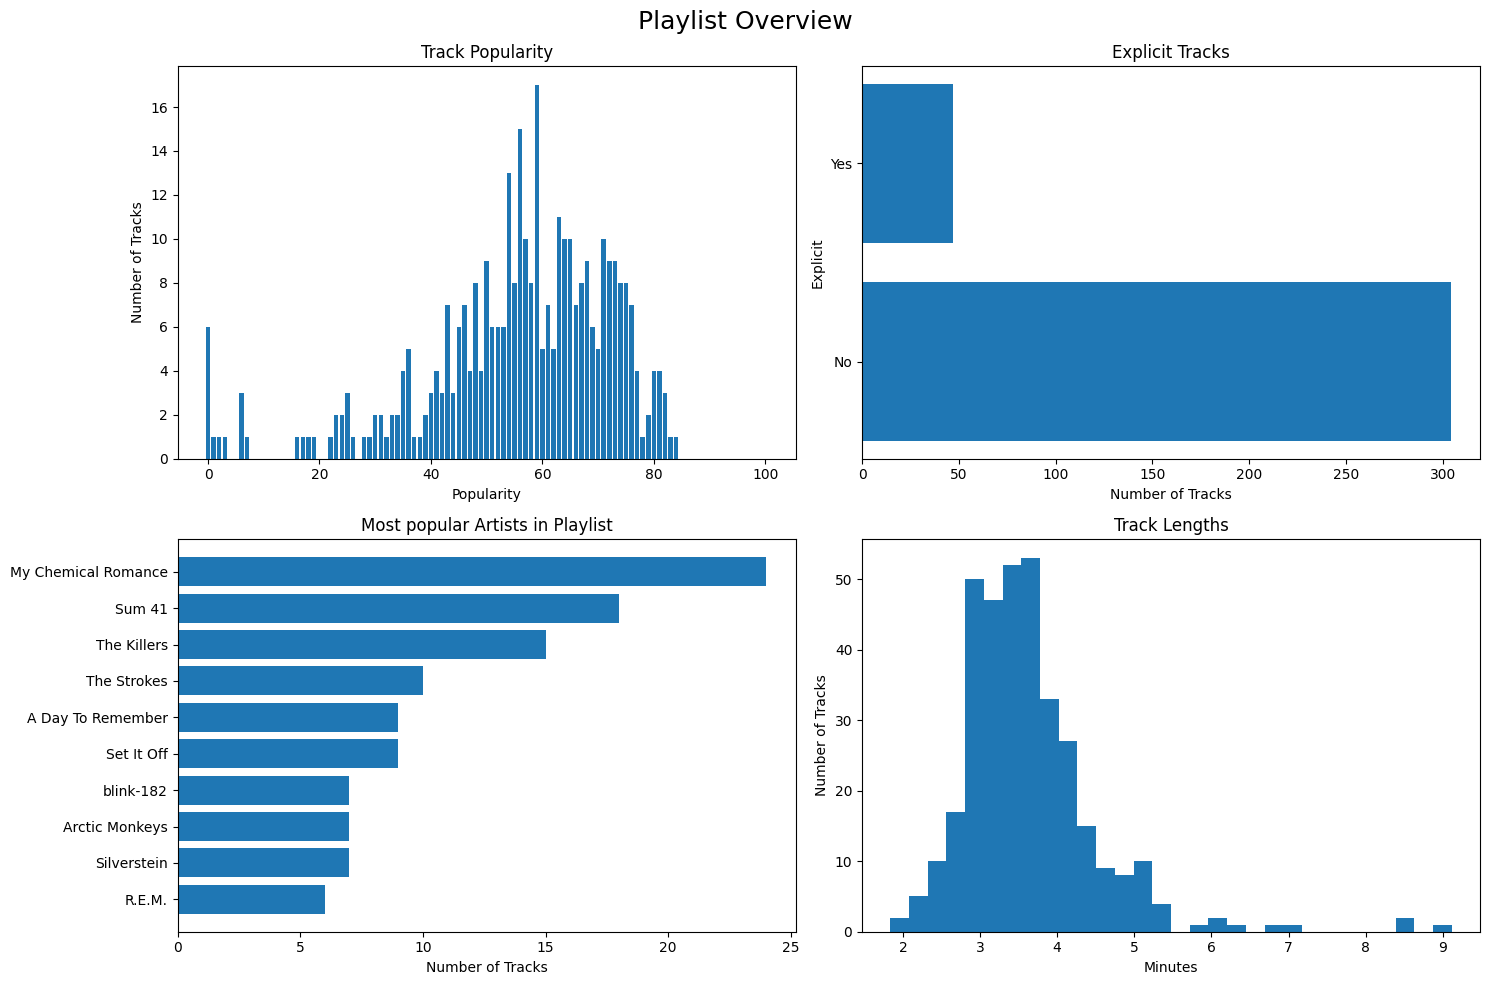

In [197]:
fig, axs = plt.subplots(2, 2, figsize=(15, 10))

# Plot 1
axs[0, 0].bar(playlist_analysis_data["popularity"].keys(), playlist_analysis_data["popularity"].values())
axs[0, 0].set_ylabel('Number of Tracks')
axs[0, 0].set_xlabel('Popularity')
axs[0, 0].set_title('Global Track Popularity')

# Plot 2
axs[0, 1].barh(["No", "Yes"], playlist_analysis_data["explicit_track"].values())
axs[0, 1].set_ylabel('Explicit')
axs[0, 1].set_xlabel('Number of Tracks')
axs[0, 1].set_title('Explicit Tracks')

# Plot 3
axs[1, 0].barh(list(playlist_analysis_data["artists"].keys())[:10][::-1], 
               list(playlist_analysis_data["artists"].values())[:10][::-1])
axs[1, 0].set_xlabel('Number of Tracks')
axs[1, 0].set_title('Most popular Artists in Playlist')


# Plot 4
axs[1, 1].hist(playlist_analysis_data["track_lengths"], bins=30)
axs[1, 1].set_title('Track Lengths')
axs[1, 1].set_xlabel('Minutes')
axs[1, 1].set_ylabel('Number of Tracks')

plt.suptitle("Playlist Overview", size=18)
plt.tight_layout()
plt.show()